In [79]:
from massa_mola_2_corpos.dataset import get_position_and_force, build_dataset, k_matrix, c_matrix, m_matrix
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

$\ddot{q} = M^{-1}(f - Kq - C\dot{q}) - g $

In [80]:
dt = 0.001
k = [2, 2]
m = [10, 15]
c = [9, 7]
pos, force = get_position_and_force(dt=dt, k=k, m=m, c=c, steps=50000)

100%|██████████| 50000/50000 [00:51<00:00, 968.99it/s] 


In [81]:
pos

array([[ 0.00000000e+00,  1.00000000e+00],
       [-5.00348960e-06,  9.99995028e-01],
       [-2.00079168e-05,  9.99980113e-01],
       ...,
       [ 2.47048199e+01, -4.86159964e+01],
       [ 2.47044159e+01, -4.86160650e+01],
       [ 2.47040120e+01, -4.86161338e+01]])

In [82]:
def add_noise(x, scale=0.05):
    return scale*np.random.normal(size=x.shape)

In [83]:
q, q_dot, q_dot2, f = build_dataset(pos, force, dt=dt)
f = f.reshape((-1, 1))


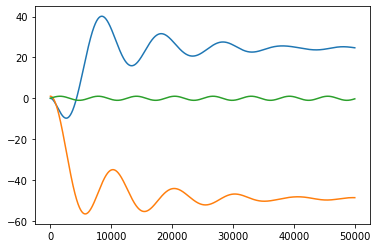

In [84]:

plt.plot(q)
#plt.plot(q_dot)
#plt.plot(q_dot2)
plt.plot(f)
plt.show()

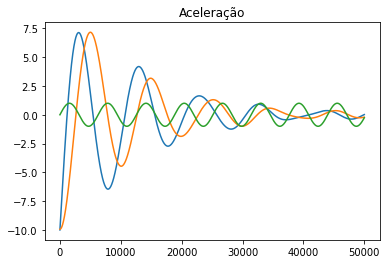

In [85]:
plt.plot(q_dot2)
plt.plot(f)
plt.title("Aceleração")
plt.show()

# Treinamento

In [112]:
from jax import random
from jax.experimental.optimizers import adam, sgd
%load_ext autoreload
%autoreload 2
from models.newton import mse, initialize_params, get_batch_forward_pass, get_loss_function, train
from tqdm import tqdm

from utils import Shuffler

rng = random.PRNGKey(20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
params = initialize_params(rng, dims=2)
batch_forward_pass = get_batch_forward_pass(mass=m_matrix(m))

In [114]:

shuffler = Shuffler(len(q))
q_shuffled = shuffler.shuffle(q)
q_dot_shuffled = shuffler.shuffle(q_dot)
q_dot2_shuffled = shuffler.shuffle(q_dot2)
f_shuffled = shuffler.shuffle(f)

In [115]:
params

[DeviceArray([[-0.6630825 , -0.5782476 ],
              [ 0.20764129,  0.9427113 ]], dtype=float32),
 DeviceArray([[-1.4662489 , -0.8464475 ],
              [ 0.6290237 ,  0.26404384]], dtype=float32)]

  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 0


100%|██████████| 390/390 [00:03<00:00, 114.48it/s]


Epoch 0 , mean error: 5194.824 params: [DeviceArray([[-0.00418434,  1.9978281 ],
             [-1.9603438 ,  2.0206947 ]], dtype=float32), DeviceArray([[ 1.9977301,  7.005305 ],
             [-6.9549713,  6.949872 ]], dtype=float32)]


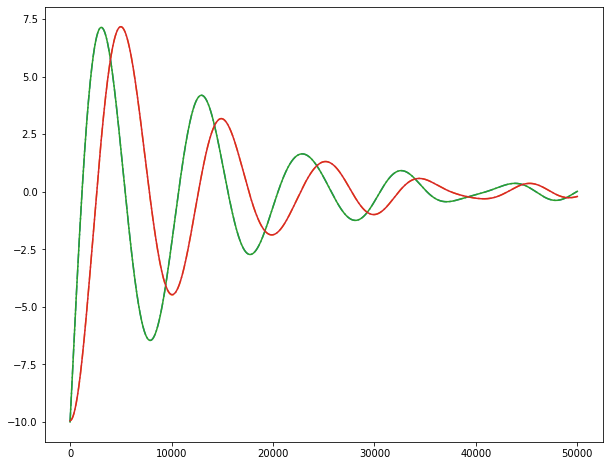

  2%|▏         | 6/390 [00:00<00:06, 55.69it/s]

Epoch 1


100%|██████████| 390/390 [00:05<00:00, 77.30it/s] 


Epoch 1 , mean error: 2.3571342e-06 params: [DeviceArray([[-1.3293483e-03,  1.9993263e+00],
             [-1.9993566e+00,  2.0003271e+00]], dtype=float32), DeviceArray([[ 2.0009494,  7.001546 ],
             [-6.9974756,  7.0005555]], dtype=float32)]


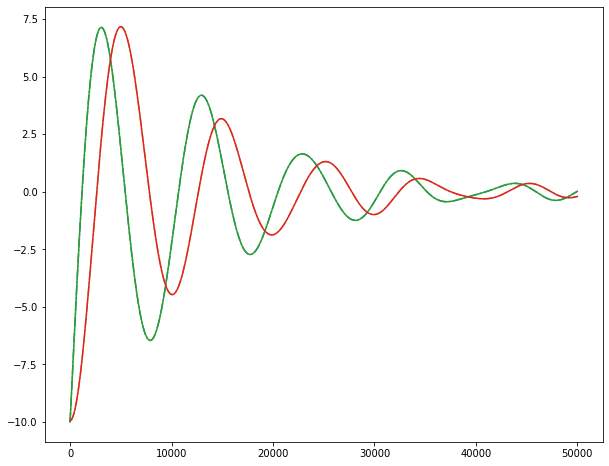

  2%|▏         | 8/390 [00:00<00:04, 79.84it/s]

Epoch 2


 54%|█████▍    | 210/390 [00:03<00:02, 69.71it/s]


KeyboardInterrupt: 

In [116]:


def callback(y_pred, y_true):
    
    plt.figure(figsize=(10, 8))
    plt.plot(shuffler.undo_shuffle(np.squeeze(y_pred)), linestyle="-.")
    plt.plot(shuffler.undo_shuffle(np.squeeze(y_true)))
    plt.show()


train(params, q_shuffled, q_dot_shuffled, q_dot2_shuffled, f_shuffled, batch_size=128, optimizer=adam, step_size=1e2, epochs=10, callback=callback, batch_forward_pass=batch_forward_pass)

In [163]:
indexes = [i for i in range(len(q))]
np.random.shuffle(indexes)

q = q[indexes]
q_dot = q_dot[indexes]
q_dot2 = q_dot2[indexes]
f = f[indexes]
    
undo_shuffle = onp.argsort(indexes)

Epoch 0



Epoch 0 , mean error: 1.8720957 params: [DeviceArray([[-0.6593292,  1.6500425],
             [-1.0221337,  2.5195696]], dtype=float32), DeviceArray([[ 1.2940574,  8.077591 ],
             [-5.932562 ,  5.4222283]], dtype=float32)]


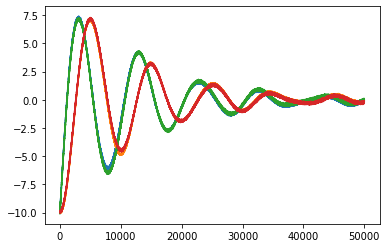

Epoch 1



Epoch 1 , mean error: 0.023493787 params: [DeviceArray([[-0.5049208,  1.7318968],
             [-1.268729 ,  2.388892 ]], dtype=float32), DeviceArray([[ 1.4593412,  7.824854 ],
             [-6.1990776,  5.8217616]], dtype=float32)]


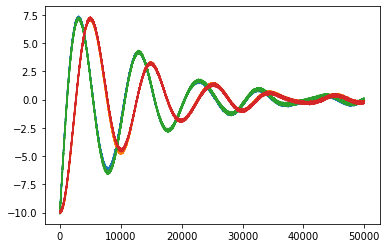

Epoch 2



Epoch 2 , mean error: 0.014522743 params: [DeviceArray([[-0.364486 ,  1.8062009],
             [-1.4860141,  2.2737968]], dtype=float32), DeviceArray([[ 1.6096275,  7.5950084],
             [-6.433902 ,  6.173922 ]], dtype=float32)]


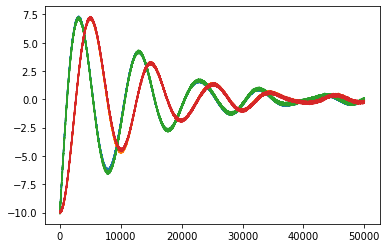

Epoch 3



Epoch 3 , mean error: 0.00892541 params: [DeviceArray([[-0.24458574,  1.8696022 ],
             [-1.6646183 ,  2.179081  ]], dtype=float32), DeviceArray([[ 1.7382313,  7.398593 ],
             [-6.62716  ,  6.4634085]], dtype=float32)]


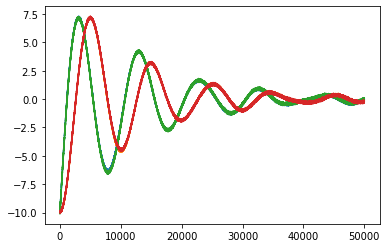

Epoch 4



Epoch 4 , mean error: 0.005889082 params: [DeviceArray([[-0.14987324,  1.9198695 ],
             [-1.7993867 ,  2.107193  ]], dtype=float32), DeviceArray([[ 1.8404061,  7.2430363],
             [-6.7735653,  6.6818666]], dtype=float32)]


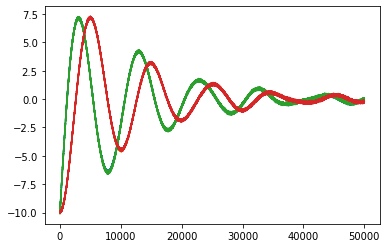

Epoch 5



Epoch 5 , mean error: 0.004499772 params: [DeviceArray([[-0.08174451,  1.9562757 ],
             [-1.8912039 ,  2.057931  ]], dtype=float32), DeviceArray([[ 1.9144597,  7.130736 ],
             [-6.8738565,  6.830349 ]], dtype=float32)]


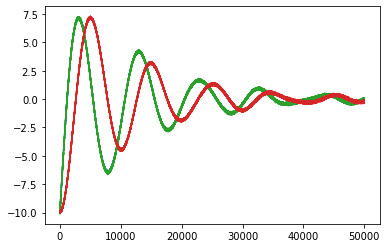

Epoch 6



Epoch 6 , mean error: 0.003982161 params: [DeviceArray([[-0.03798767,  1.9798875 ],
             [-1.9468294 ,  2.0284824 ]], dtype=float32), DeviceArray([[ 1.9624096,  7.058339 ],
             [-6.9347672,  6.919031 ]], dtype=float32)]


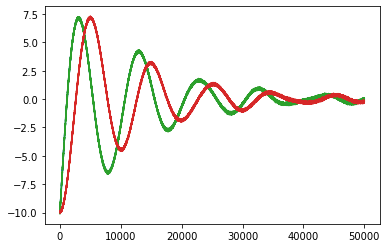

Epoch 7



Epoch 7 , mean error: 0.0038310234 params: [DeviceArray([[-0.01312642,  1.9929606 ],
             [-1.9763031 ,  2.0138228 ]], dtype=float32), DeviceArray([[ 1.9896827,  7.0178146],
             [-6.9662437,  6.9641676]], dtype=float32)]


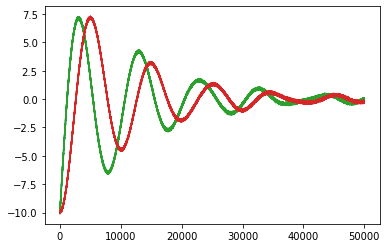

Epoch 8



Epoch 8 , mean error: 0.0038023717 params: [DeviceArray([[-5.7267206e-04,  1.9987028e+00],
             [-1.9888090e+00,  2.0072107e+00]], dtype=float32), DeviceArray([[ 2.002974 ,  6.9987736],
             [-6.979189 ,  6.9830627]], dtype=float32)]


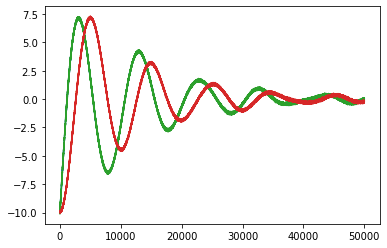

Epoch 9



Epoch 9 , mean error: 0.003802625 params: [DeviceArray([[ 0.00488413,  2.0007317 ],
             [-1.993251  ,  2.0047927 ]], dtype=float32), DeviceArray([[ 2.0075207,  6.991714 ],
             [-6.984016 ,  6.9891863]], dtype=float32)]


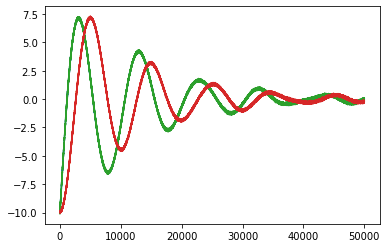

In [164]:
step_size = 1e-1
batch_size = 128
epochs = 10
init_fun, opt_update, get_params = adam(step_size=step_size)

params = initialize_params(rng, dims=2)
opt_state = init_fun(params)



def train_step(q, q_dot, q_dot2, f, opt_state, opt_update):
    params = get_params(opt_state)
    mse, grad = value_and_grad(loss)(params, q, q_dot, q_dot2, f)
    opt_state = opt_update(0, grad, opt_state)
    params = get_params(opt_state)
    return get_params(opt_state), opt_state, mse


#def train_epoch(batch_size, q, q_dot, q_dot2, f, opt_state, opt_update):

epoch_errors = []
params_history = []
for epoch in range(epochs):

    n_batchs = len(q)//batch_size
    errors = []


    print("Epoch", epoch)
    for i in tqdm(range(n_batchs)):
        q_batch      = jnp.array(q[i*batch_size:((i+1)*batch_size)])
        q_dot_batch  = jnp.array(q_dot[i*batch_size:((i+1)*batch_size)])
        q_dot2_batch = jnp.array(q_dot2[i*batch_size:((i+1)*batch_size)])
        f_batch = jnp.array(f[i*batch_size:((i+1)*batch_size)])
        params, opt_state, error = train_step(q_batch, q_dot_batch, q_dot2_batch, f_batch, opt_state, opt_update)
        errors.append(error)
        params_history.append(params.copy())

    mean_error = np.mean(np.array(errors))
    print("Epoch", epoch, ", mean error:",mean_error, "params:", params)
    epoch_errors.append(mean_error)

    y_pred = np.array(batch_forward_pass(params, q, q_dot, f))
    plt.plot(np.squeeze(y_pred)[undo_shuffle])
    plt.plot(np.squeeze(q_dot2)[undo_shuffle])
    plt.show()



In [134]:
params_history = np.array(params_history)

In [135]:
params_history.shape

(3900, 2, 2, 2)

In [136]:
params_history[:, 0]

array([[[-0.7630825 , -0.47824758],
        [ 0.10764129,  1.0427113 ]],

       [[-0.8968519 , -0.3438896 ],
        [-0.02649108,  1.1772562 ]],

       [[-1.052016  , -0.18813105],
        [-0.18220764,  1.332893  ]],

       ...,

       [[-0.5886361 ,  1.6941425 ],
        [-2.2217147 ,  1.8914803 ]],

       [[-0.5894155 ,  1.695437  ],
        [-2.2231655 ,  1.8915921 ]],

       [[-0.59008473,  1.6958857 ],
        [-2.223903  ,  1.8912514 ]]], dtype=float32)

In [137]:
params_history[0][0]

array([[-0.7630825 , -0.47824758],
       [ 0.10764129,  1.0427113 ]], dtype=float32)

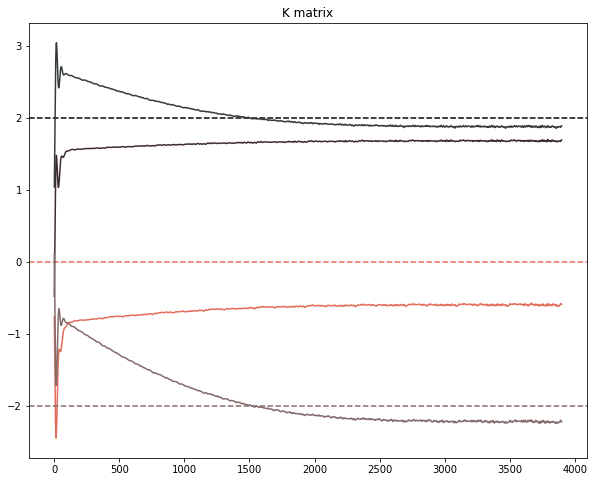

In [138]:
param_index = 0
colors = ["#E26D5A", "#3E2A35", "#846a6a", "#353b3c"]
K = params_history[:, param_index].reshape((-1, 4))

plt.figure(figsize=(10,8))
plt.title("K matrix")
for i in range(4):
    plt.plot(K[:, i], color=colors[i])
    plt.axhline(true_params[param_index].flatten()[i], color=colors[i], linestyle="dashed")

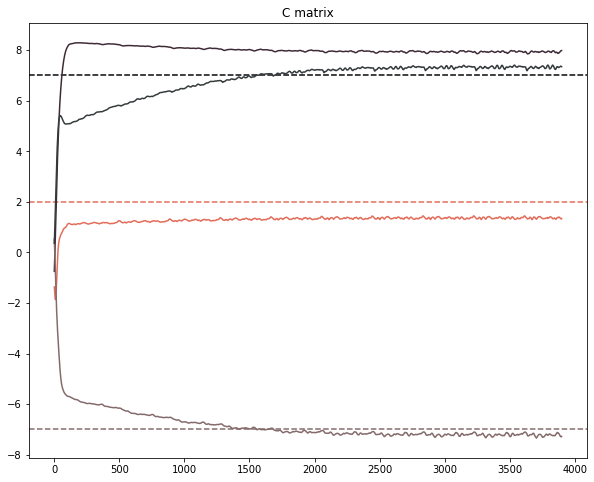

In [139]:
param_index = 1
colors = ["#E26D5A", "#3E2A35", "#846a6a", "#353b3c"]
K = params_history[:, param_index].reshape((-1, 4))

plt.figure(figsize=(10,8))
plt.title("C matrix")
for i in range(4):
    plt.plot(K[:, i], color=colors[i])
    plt.axhline(true_params[param_index].flatten()[i], color=colors[i], linestyle="dashed")